### iQuHack 2023
### Event: Quantinuum
### Team: Jaydin, David, Imaan, Jack, Ken
### Description: 
In this iQuHack, we will work on improving the given QAOA implemntation for solving the Max-Cut problem. We will test and implement more sophisticated optimization strategies such as COBYLA and SPSA to see if they can improve the performance of the given implementation. The project will involve coding and testing in Python using networkx and open-source libraries. By the end, we will have a better understanding of the performance of QAOA and a working implementation using advanced optimization strategies.

### Problem: 
Imagine you have a big picture with lots of dots (nodes) and lines (edges) connecting some of the dots. We want to color some of the dots red and the rest blue in a way that there are as many lines as possible connecting dots of different colors.

### Current Options:

QAOA Implementation: The given implementation as mentioned in the description uses a naive approach that starts by guessing some angles and then checks if this guess is better than the best guess it had before. If it is, then it saves this new guess as the best one. It does this many times, and at the end it tells you what the best guess is and how well it worked. It's like if you were trying to solve a jigsaw puzzle by trying different ways to put the pieces together, and you keep the best way you found so far.

We're given three paradigms to approach the issue

* Quantum Approximate Optimization Algorithm (QAOA) - Uses quantum gates to create a special picture of the problem and finds the best solution by changing that picture with different parameters. 

* Constrained Optimization by linear Approximation Optimizer (COBYLA) - Is a gradient-free optimization algorithm used to find the best solution to the max-cut problem by dividing the dots into two groups. 

* Simultaneous Pertubation Stochatic Approximation Optimizer (SPSAO) - Is a stochastic optimization algorithm that uses gradient information to adjust parameters and finds the best solution by making small changes to the initial guess.


### Circuit Construction for QAOA:

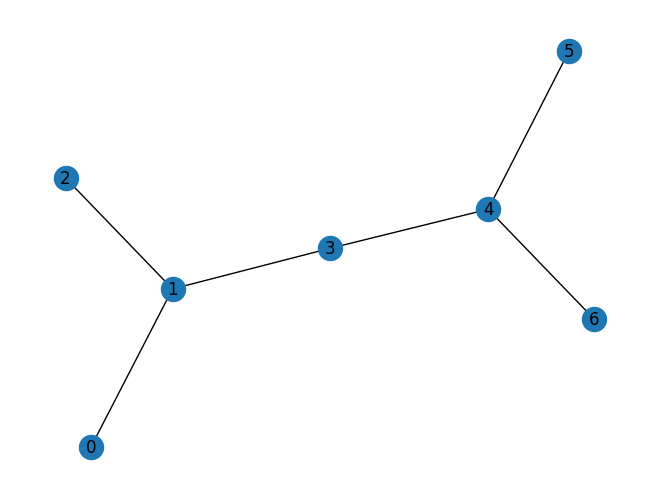

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

max_cut_graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0,1,0,0,1,0,0), (1,0,1,1,0,1,1)]

### Define Cost Hamiltonian: $\gamma H$

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{<jk>} (-Z_j \,Z_k +I )
\end{equation}
$$

In [2]:
from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5*cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, cost_angle)
print(cost_ham_qpo)

{(): 3.00000000000000, (Zq[0], Zq[1]): -0.500000000000000, (Zq[1], Zq[2]): -0.500000000000000, (Zq[1], Zq[3]): -0.500000000000000, (Zq[3], Zq[4]): -0.500000000000000, (Zq[4], Zq[5]): -0.500000000000000, (Zq[4], Zq[6]): -0.500000000000000}


### Hamiltonian Circuit

In [3]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(n_nodes))
display.render_circuit_jupyter(cost_ham_circuit)

In [4]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

### Construction of the Mixer Hamiltonian: $\beta B$


In [5]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(n_nodes)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(n_nodes))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

### Define the Initial State

In [6]:
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(n_nodes)

display.render_circuit_jupyter(superposition_circuit)

### Construct QAOA Circuit

Now lets define a function to create our entire QAOA circuit. For $p$ QAOA layers we expect that our circuit will require $2p$ parameters. Here we will pass and cost mixer parameters in as a list where the length of the list defines the number of layers.

In [7]:
def qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                         n_nodes: int,
                         mixer_angles: List[float],
                         cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = qaoa_initial_circuit(n_nodes)
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(edges, cost)
        mixer_ham = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)})
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

We also need to extract our energy expectation values from a `BackendResult` object after our circuit is processed by the device/simulator. We do this with the `get_max_cut_energy` function below. Note that the fact that the maxcut Hamiltonian contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits. This may not the the case for a different problem Hamiltonian.

In [8]:
from typing import List, Tuple
from pytket.backends.backendresult import BackendResult

def get_max_cut_energy(edges: List[Tuple[int, int]], results: BackendResult) -> float:
    energy = 0.0
    dist = results.get_distribution()
    for i, j in edges:
        energy += sum((meas[i] ^ meas[j]) * prob for meas, prob in dist.items())

    return energy

In [9]:
from pytket.backends.backend import Backend
from typing import Callable
import numpy as np

def qaoa_instance(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    seed: int,
    shots: int = 500,
) -> float:
    # step 1: get state guess
    my_prep_circuit = qaoa_max_cut_circuit(
        max_cut_graph_edges, n_nodes, guess_mixer_angles, guess_cost_angles
    )
    # step 2: measure state
    measured_circ = my_prep_circuit.copy().measure_all()
    compiler_pass(measured_circ)
    res = backend.run_circuit(measured_circ, shots, seed=seed)


    return get_max_cut_energy(max_cut_graph_edges, res)

### [IMPLEMENTATION BELOW] Optimise Energy by Guessing Parameters

In order to try each of the functions below you have to F2 rename one of the methods listed below and change the name to 'qaoa_optimise_energy'

### Nelder-Mead

The Nelder–Mead method (also downhill simplex method, amoeba method, or polytope method) is a numerical method used to find the minimum or maximum of an objective function in a multidimensional space. It is a direct search method (based on function comparison) and is often applied to nonlinear optimization problems for which derivatives may not be known. However, the Nelder–Mead technique is a heuristic search method that can converge to non-stationary points[1] on problems that can be solved by alternative methods

In [10]:
from scipy.optimize import minimize


def qaoa_optimise_energy_Nelder_Mead(
    compiler_pass: Callable[[Circuit], bool],
    backend: Backend,
    iterations: int = 5,
    n: int = 3,
    shots: int = 5000,
    seed: int = 12345,
):

    highest_energy = 0
    best_guess_mixer_angles = [0 for i in range(n)]
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)

    # define cost function
    def max_cut_cost_hamiltonian(angles):
        mixer_angles = angles[:n]
        cost_angles = angles[n:]
        return -qaoa_instance(
            backend, compiler_pass, mixer_angles, cost_angles, seed=seed, shots=shots
        )

    # guess some angles (iterations)-times and try if they are better than the best angles found before
    for i in range(iterations):

        initial_angles = rng.uniform(0, 1, 2 * n)
        res = minimize(max_cut_cost_hamiltonian, initial_angles, method="Nelder-Mead")

        if -res.fun > highest_energy:
            print("new highest energy found: ", -res.fun)

            best_guess_mixer_angles = np.round(res.x[:n], 3)
            best_guess_cost_angles = np.round(res.x[n:], 3)
            highest_energy = -res.fun

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles


### Basin Hopping

Uses the basinhopping function from scipy.optimize, which is an implementation of simulated annealing. This function takes an initial set of angles, and applies small random perturbations to them in order to explore the parameter space. It then calls the max_cut_cost_hamiltonian function, which in turn calls the qaoa_instance function to evaluate the energy of the output state. The basinhopping function will then return the set of angles that results in the highest energy.

"The quantum basin hopping algorithm for continuous global optimisation combines a local search with Grover’s algorithm, and can locate the global optimum using effort proportional to the square root of the number of basins."

In [11]:
from scipy.optimize import minimize, basinhopping

def qaoa_optimise_energy_basin_hopping(
    compiler_pass: Callable[[Circuit], bool],
    backend: Backend,
    iterations: int = 5,
    n: int = 3,
    shots: int = 5000,
    seed: int = 12345,
):

    highest_energy = 0
    best_guess_mixer_angles = [0 for i in range(n)]
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)

    #define cost function
    def max_cut_cost_hamiltonian(angles):
        mixer_angles = angles[:n]
        cost_angles = angles[n:]
        return -qaoa_instance(
            backend, compiler_pass, mixer_angles, cost_angles, seed=seed, shots=shots
        )

    #guess some angles (iterations)-times and try if they are better than the best angles found before
    for i in range(iterations):

        initial_angles = rng.uniform(0, 1, 2 * n)
        res = basinhopping(max_cut_cost_hamiltonian, initial_angles, niter=5)
        
        if -res.fun > highest_energy:
            print("new highest energy found: ", -res.fun)

            best_guess_mixer_angles = np.round(res.x[:n], 3)
            best_guess_cost_angles = np.round(res.x[n:], 3)
            highest_energy = -res.fun

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles


### Starting Function

In [12]:
def qaoa_optimise_energy_starting_point(
    compiler_pass: Callable[[Circuit], bool],
    backend: Backend,
    iterations: int = 5,
    n: int = 3,
    shots: int = 5000,
    seed: int = 12345,
):

    highest_energy = 0
    best_guess_mixer_angles = [0 for i in range(n)]
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)

    # guess some angles (iterations)-times and try if they are better than the best angles found before
    for i in range(iterations):

        guess_mixer_angles = rng.uniform(0, 1, n)
        guess_cost_angles = rng.uniform(0, 1, n)

        qaoa_energy = qaoa_instance(
            backend,
            compiler_pass,
            guess_mixer_angles,
            guess_cost_angles,
            seed=seed,
            shots=shots,
        )

        if qaoa_energy > highest_energy:

            print("new highest energy found: ", qaoa_energy)

            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles


### Calculate the State for the final Parameters

In [13]:
def qaoa_calculate(backend: Backend,
                   compiler_pass: Callable[[Circuit], bool],
                   shots: int = 5000,
                   iterations: int = 5,
                   seed: int = 12345,
                  ) -> BackendResult:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 3,
                                                 shots=shots,
                                                 seed=seed)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots, seed=seed)

    result = backend.get_result(handle)    
    
    return result

### Results with the Noiseless Simulator

In [14]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

In [15]:
%%time
res = qaoa_calculate(backend, backend.default_compilation_pass(0).apply, shots = 5000, iterations = 5, seed=12345)

NameError: name 'qaoa_optimise_energy' is not defined

### Visualization

In [ ]:
from maxcut_plotting import plot_maxcut_results

plot_maxcut_results(res, 6)

In [ ]:
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(G, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['red', 'blue', 'red','red', 'blue', 'red', 'red'])
plt.figure(2)
nx.draw(H, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue'])

plt.show()